## embedding timeseries in a lazy dask framework?



In [1]:
%matplotlib notebook

import yt 
import dask 
import numpy as np
yt.set_log_level(50)  # disable yt logging

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1, n_workers=7)  # NOT THREAD SAFE!!!!!

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 7
Total threads: 7,Total memory: 30.93 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39633,Workers: 7
Dashboard: http://127.0.0.1:8787/status,Total threads: 7
Started: Just now,Total memory: 30.93 GiB
Comm: tcp://127.0.0.1:36043,Total threads: 1
Dashboard: http://127.0.0.1:44547/status,Memory: 4.42 GiB
Nanny: tcp://127.0.0.1:45903,


In [4]:
import glob 
import yt 
import os 

In [49]:
yt_data_dir = yt.config.ytcfg.get('yt', 'test_data_dir')
ds_files = glob.glob(os.path.join(yt_data_dir, "enzo_tiny_cosmology/DD????/DD????"))
ds_files.sort()

In [50]:
import numpy as np

In [51]:
%%time

basenames = [] 

def center_slice_frb(ds_id, field):  
    yt.set_log_level(50)  # disable yt logging here...
    ds = yt.load(ds_files[ds_id])
    slc = ds.slice(0, ds.domain_center[0])    
    return slc.to_frb(1., (400, 400))[field]

field = ('enzo', 'Density')
for ds_id in range(len(ds_files)):     
    basenames.append(dask.delayed(center_slice_frb)(ds_id, field))

CPU times: user 12.1 ms, sys: 179 µs, total: 12.3 ms
Wall time: 10.4 ms


In [52]:
%%time
slices = dask.compute(*basenames)

Parsing Hierarchy : 100%|██████████| 94/94 [00:00<00:00, 1404.85it/s]


CPU times: user 23 s, sys: 3.83 s, total: 26.9 s
Wall time: 1min 9s


In [53]:
len(slices)

47

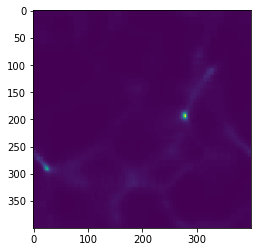

In [57]:
slices[0]

array([[0.18466163, 0.18466163, 0.18466163, ..., 0.17276843, 0.17276843,
        0.17276843],
       [0.18466163, 0.18466163, 0.18466163, ..., 0.17276843, 0.17276843,
        0.17276843],
       [0.18466163, 0.18466163, 0.18466163, ..., 0.17276843, 0.17276843,
        0.17276843],
       ...,
       [0.16784802, 0.16784802, 0.16784802, ..., 0.16170937, 0.16170937,
        0.16170937],
       [0.16784802, 0.16784802, 0.16784802, ..., 0.16170937, 0.16170937,
        0.16170937],
       [0.16784802, 0.16784802, 0.16784802, ..., 0.16170937, 0.16170937,
        0.16170937]])

In [58]:
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets
import numpy as np 

%matplotlib inline

def g(slice_id):
    plt.imshow(np.log10(slices[slice_id]))
    plt.show()

interactive_plot = interactive(g, slice_id=widgets.IntSlider(0, 0, len(slices)-1, 1))
interactive_plot

interactive(children=(IntSlider(value=0, description='slice_id', max=46), Output()), _dom_classes=('widget-int…

## baseline comparison

In [17]:
%%time

basenames = [] 

field = ('enzo', 'Density')
for ds_id in range(len(ds_files)):     
    basenames.append(center_slice_frb(ds_id, field))

Parsing Hierarchy : 100%|███████████████████| 120/120 [00:00<00:00, 9844.24it/s]


CPU times: user 1min 21s, sys: 4.5 s, total: 1min 26s
Wall time: 1min 21s


## how bout the ts object?